# Expected number of Rock-Paper-Scissors rounds

### Math

Let $E(n)$ be the expected number of rounds until a winner is decided for $n$ starting people. Let $p_n^m$ be the probability that out of $n$ people only $m$ continue in the next round (e.g. $p_4^1$ would mean that some player won, and $p_4^4$ that there was a draw and all four people play again).

It is obvious that
$$
    E(n) = 1 + \sum_{i=1}^n p_n^i E(i).
$$

Or, when solved for $E(n)$
$$
    (1-p_n^n) E(n) = 1 + \sum_{i=1}^{n-1} p_n^i E(i).
$$

Let $C_n^m:=\frac{n!}{(n-m)!m!}$ be the "n choose m" binomial coefficient. Let $0, 1, 2$ be the figures rock, paper and scissors, respectively (or any other rotation of $(0, 1, 2)$; the required property is that the preference relation $0 \succ 1 \succ 2 \succ 0$ holds).

Take $n=5$ and $m=2$. Exactly two out of five people win in all permulations of $00111$, $11222$ and $22000$. Hence, $p_5^2 = \frac{C_3^2 C_5^2}{3^5}$ where $C_3^2$ is to choose two figures out of three (a constant for all $n, m$), $C_5^2$ is to account for all aforementioned permutations and $3^5$ is the number of all possible sets of figures for five people.

Following this logic, we have
$$
    p_n^m = \frac{C_3^2 C_n^m}{3^n} = \frac{C_n^m}{3^{n-1}}
$$
for $n > 1$, $m=1..(n-1).$

For a draw probability, use the normalization $\sum_{i=1}^n p_n^i = 1$:
$$
    p_n^n = 1 - \sum_{i=1}^{n-1} p_n^i.
$$

We now have
$$
\sum_{i=1}^{n-1} p_n^i E(n) = 1 + \sum_{i=1}^{n-1} p_n^i E(i)
$$

Using $\sum_{i=0}^n C_n^i = 2^n$, we have
$$
\frac{1}{3^{n-1}} (2^n - 2) E(n) = 1 + \frac{1}{3^{n-1}} \sum_{i=1}^{n-1} C_n^i E(i).
$$

### Simulation

In [1]:
import math
from functools import lru_cache

def binomial(n: int, k: int) -> int:
    return math.factorial(n) // math.factorial(k) // math.factorial(n - k)


@lru_cache(maxsize=None)
def expected_num_rounds(n: int) -> float:
    if n == 1:
        return 0.
    return (3**(n-1) / (2**n - 2)) * (1 + 1./3**(n-1) * sum(binomial(n, i) * expected_num_rounds(i) for i in range(1, n)))

In [2]:
import random
from statistics import mean, stdev
from collections import Counter

def sample(n: int) -> list[int]:
    return [random.randrange(3) for _ in range(n)]

def simulate_one(n: int) -> int:
    hands = sample(n)
    rounds = 0
    while n > 1:
        rounds += 1
        hands = sample(n)
        cnt = Counter(hands)
        if len(cnt) in {1, 3}:
            continue
        if cnt.keys() == {0, 1}:
            n = cnt[0]
        elif cnt.keys() == {1, 2}:
            n = cnt[1]
        elif cnt.keys() == {0, 2}:
            n = cnt[2]
        else:
            raise ValueError("Impossible")
    return rounds


def simulate(N: int, N_iter=1000) -> tuple[float, float]:
    simres = [simulate_one(N) for _ in range(N_iter)]
    return mean(simres), stdev(simres)

In [3]:
ns = list(range(2, 30))
res = [simulate(n, N_iter=2000 // n) for n in ns]
means = [el[0] for el in res]
stdevs = [el[1] for el in res]

In [5]:
expectancies = [expected_num_rounds(n) for n in ns]

In [5]:
import plotly.graph_objects as go

fig = go.Figure()
# add scatter plot with error bars
fig.add_trace(go.Scatter(x=ns, y=expectancies, mode="lines", name="analytical"))
fig.add_trace(
    go.Scatter(
        x=ns,
        y=means,
        mode="markers",
        name="simulation",
        # error_y=dict(type="data", array=stdevs, visible=True),
    )
)

fig.update_layout(
    template="plotly_dark", legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
fig.update_yaxes(type="log")
fig.show()


## Analytical: best fit

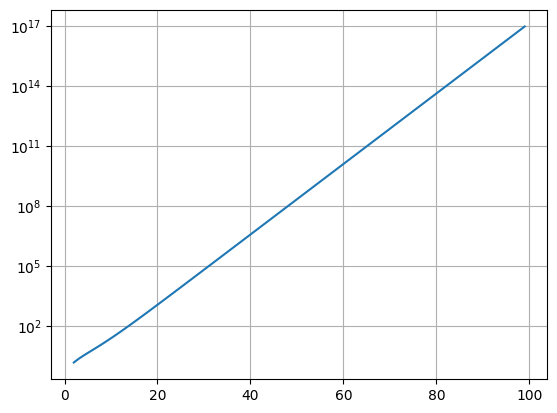

In [5]:
import numpy as np
import matplotlib.pyplot as plt


ns_an = list(range(2, 100))
expectancies_an = [expected_num_rounds(n) for n in ns_an]

plt.plot(ns_an, expectancies_an)
plt.yscale("log")
plt.grid()
plt.show()

In [9]:
coefs = np.polyfit(ns_an, np.log(expectancies_an), 1)
print(coefs)
print(np.exp(coefs[0]))

[ 0.40245941 -0.89134459]
1.4954982233429392


In [ ]:
coefs = np.polyfit(ns_an, np.log(expectancies_an), 1)

def expected_num_rounds_fit(n: int) -> float:
    return np.exp(coefs[1]) * np.exp(coefs[0] * n)

In [26]:
for n in ns:
    analytical = expected_num_rounds(n)
    fit = expected_num_rounds_fit(n)
    print(f"{n=:>02}: {analytical=:.3f} {fit=:.3f}, {(fit - analytical) / analytical:.2%}")

n=02: analytical=1.500 fit=0.917, -38.85%
n=03: analytical=2.250 fit=1.372, -39.04%
n=04: analytical=3.214 fit=2.051, -36.18%
n=05: analytical=4.486 fit=3.068, -31.61%
n=06: analytical=6.220 fit=4.588, -26.24%
n=07: analytical=8.647 fit=6.861, -20.65%
n=08: analytical=12.104 fit=10.261, -15.23%
n=09: analytical=17.092 fit=15.345, -10.22%
n=10: analytical=24.350 fit=22.948, -5.75%
n=11: analytical=34.979 fit=34.319, -1.89%
n=12: analytical=50.625 fit=51.325, 1.38%
n=13: analytical=73.740 fit=76.756, 4.09%
n=14: analytical=107.993 fit=114.788, 6.29%
n=15: analytical=158.868 fit=171.665, 8.05%
n=16: analytical=234.574 fit=256.725, 9.44%
n=17: analytical=347.395 fit=383.932, 10.52%
n=18: analytical=515.729 fit=574.170, 11.33%
n=19: analytical=767.136 fit=858.670, 11.93%
n=20: analytical=1142.903 fit=1284.139, 12.36%
n=21: analytical=1704.905 fit=1920.427, 12.64%
n=22: analytical=2545.878 fit=2871.996, 12.81%
n=23: analytical=3804.833 fit=4295.065, 12.88%
n=24: analytical=5690.171 fit=6423.